In [90]:
from typing import Callable, List
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [91]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates cartesian product of points in arrays.

Это функция взята с Stack Overflow, я понятия не имею, как она работает, и не хочу иметь.
"""
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to len(t) ** (len(b) - 1).


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. num - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param t: list describing basis linspace for dataset

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List, k:int, t:ndarray = np.linspace(0, 10, 50)) -> List[List]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = cartesian_product(*[t]*dim)
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = (b * cartesian_product(*[t]*dim)).sum(axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@return list of terms of generated function
"""
def generate_minimized_fun(t:List, ft:List) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i] and ft[i] from current context
        sum_fun[i] = partial(lambda t, ft, a: 1 / len(t) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i])
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@return list of points representing path of sgd. The last point of the list is found minimum point.
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    for i in range(1, epoch):
        x = x - 1 / batch_size * scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        points[i] = x
    return points

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

[8.81912298 4.95826888]
[[0.         0.        ]
 [2.05426244 1.27108269]
 [3.45052678 2.52884304]
 [4.11616826 3.26766024]
 [4.32205113 3.5282055 ]
 [5.3124923  4.01357539]
 [5.53856003 4.38298068]
 [5.85434302 4.49341412]
 [6.36044344 4.558429  ]
 [6.69425734 4.62609427]
 [6.93824471 4.81794087]
 [7.18920098 4.70952807]
 [7.68838676 4.83237278]
 [7.96200328 4.81523667]
 [8.051085   4.8489047 ]
 [8.27287979 4.8765742 ]
 [8.42606442 4.9428709 ]
 [8.44665745 4.95001831]
 [8.70895066 5.0253259 ]
 [8.81912298 4.95826888]]


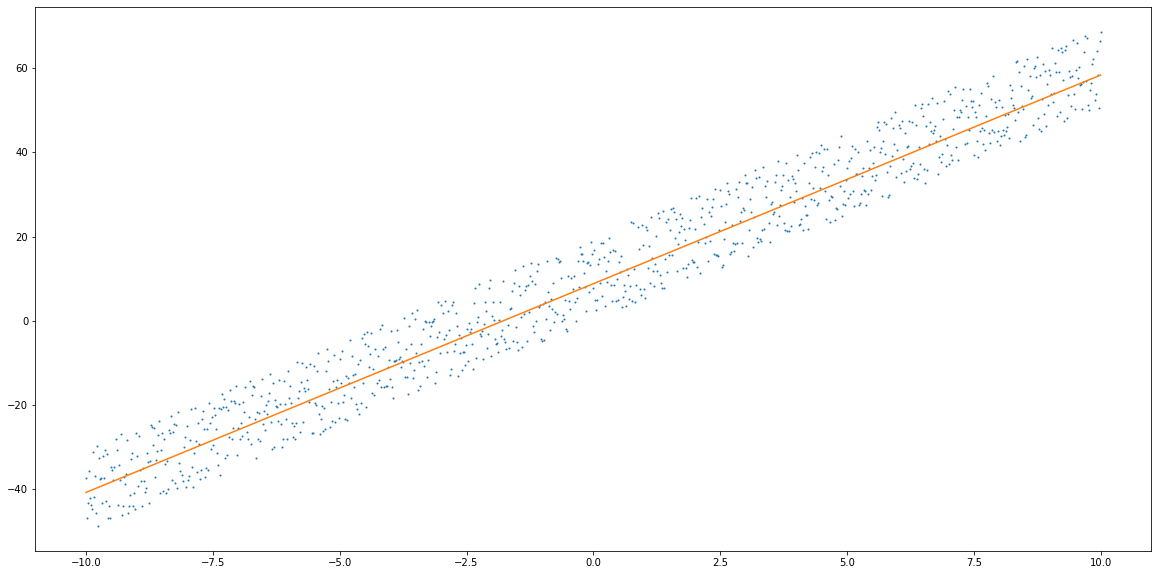

In [92]:
tt = np.linspace(-10, 10, 1000)
b = [10, 5]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [0.05, 0.004]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point)
print(points)

# Plots dataset
plt.plot(t, ft, 'o', markersize=1)
# Plots approximated function
plt.plot(tt, min_point[1] * tt + min_point[0])

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

[9.2081847  1.90672699 3.95321348]
[[0.         0.         0.        ]
 [0.34161805 0.24678487 0.59906106]
 [1.1973229  0.36282028 1.19285368]
 [1.73158849 0.39884152 1.37401942]
 [2.09770795 0.44638603 1.95353855]
 [2.55181958 0.60610344 2.27069469]
 [2.91447716 0.74801078 2.49053468]
 [3.35576906 0.79141402 2.6563866 ]
 [3.66156715 0.92314236 2.84675765]
 [3.95369298 1.04098399 2.96370403]
 [4.25145499 1.09019051 3.10592724]
 [4.52750824 1.15760773 3.23904632]
 [4.79750996 1.18288253 3.30859038]
 [5.11120963 1.2643175  3.41493647]
 [5.26435278 1.31242957 3.48941232]
 [5.48447715 1.3412072  3.51306612]
 [5.79731809 1.38403717 3.56827839]
 [5.9875217  1.40661612 3.62751444]
 [6.12670517 1.43749621 3.69026254]
 [6.39950448 1.46741119 3.74302336]
 [6.61954656 1.50103981 3.76914032]
 [6.8641874  1.54677188 3.75456324]
 [6.98829182 1.54908643 3.76158872]
 [7.04755414 1.56935393 3.84366999]
 [7.04617998 1.60277088 3.86473958]
 [7.15339319 1.60122955 3.88726333]
 [7.22798779 1.62545827 3.869

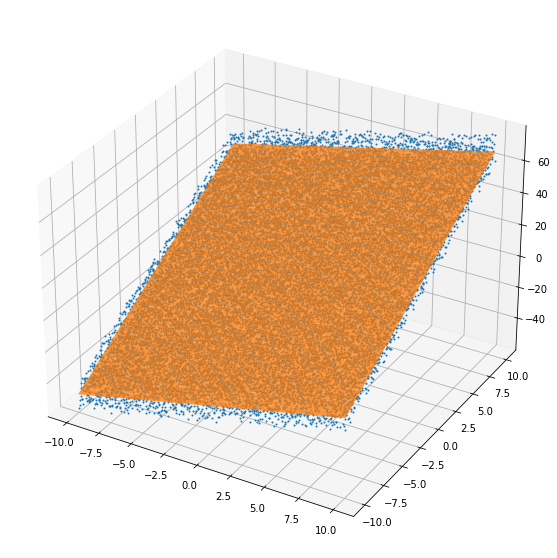

In [93]:
tt = np.linspace(-10, 10, 150)
b = [10, 2, 4]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [0.05, 0.002, 0.004]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point)
print(points)

ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [94]:
tt = np.linspace(-10, 10, 20)
b = [10, 2, 4, 5, -3]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [0.1, 0.002, 0.004, 0.005, 0.003]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point - b)
print(min_point)
print(points)

[-2.01571727 -0.28549911 -0.22442409 -0.25793569  0.11304875]
[ 7.98428273  1.71450089  3.77557591  4.74206431 -2.88695125]
[[ 0.          0.          0.          0.          0.        ]
 [-0.95935938  0.18494157 -0.04226178  0.5215968  -0.04814003]
 [-1.59674882  0.26074129  0.09357527  0.59518502  0.04308164]
 [ 0.44244029  0.37507366  0.14174583  1.1519596  -0.07974664]
 [ 1.0768374   0.4298476   0.20398428  1.07416153 -0.08975501]
 [ 3.61834777  0.58622296  0.82314402  1.96378445 -0.41089505]
 [ 3.27015352  0.64221298  1.01447023  2.60200257 -0.60543847]
 [ 5.00662257  0.86718967  1.32413776  2.80250509 -0.94666671]
 [ 5.00662694  0.82064964  1.43811579  2.83337641 -0.95521134]
 [ 5.05095954  0.94403465  1.49791845  2.93403252 -0.9151994 ]
 [ 4.34471353  1.0208423   1.90602211  2.97651297 -1.21695734]
 [ 5.39725329  1.09046165  2.04755181  3.24296577 -1.25501193]
 [ 5.17193148  1.1223483   1.97130374  3.41858871 -1.3437655 ]
 [ 5.31732369  1.14803843  1.91775178  3.63940767 -1.4213

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров

[[7.98262540e-01 1.49132094e-02 2.12155045e-01]
 [7.52796162e-01 2.20132840e-01 2.70456680e-02]
 [3.41332445e-01 3.71912799e-02 1.91311979e-01]
 [1.22351479e-01 5.93021887e-02 6.12695326e-02]
 [5.14764889e-01 1.12314597e-02 1.70430607e-01]
 [2.48125713e-01 2.35153279e-02 6.04132843e-02]
 [4.04371275e-01 1.97634676e-02 1.50689513e-01]
 [4.94407861e-01 5.71204561e-02 4.49761959e-02]
 [4.10524135e-01 2.69944139e-02 1.15710734e-01]
 [6.41246955e-01 3.91680203e-02 7.84060661e-04]
 [4.46285614e-01 3.44856299e-02 9.65749572e-02]
 [7.21286019e-01 2.88256547e-02 1.29350089e-03]
 [5.00344120e-01 4.10446607e-02 6.47927402e-02]
 [6.30341852e-01 3.20654585e-02 1.49593525e-02]
 [4.65478129e-01 4.04959481e-02 6.34730405e-02]
 [7.11971890e-01 3.16562830e-02 4.79882389e-02]
 [5.06082531e-01 4.64695544e-02 6.90533063e-02]
 [6.42133106e-01 4.26057946e-02 5.00853109e-02]
 [5.12313697e-01 4.54520271e-02 6.67221252e-02]
 [6.39835172e-01 3.75075047e-02 4.55726725e-02]
 [5.06080325e-01 3.72748219e-02 4.935913

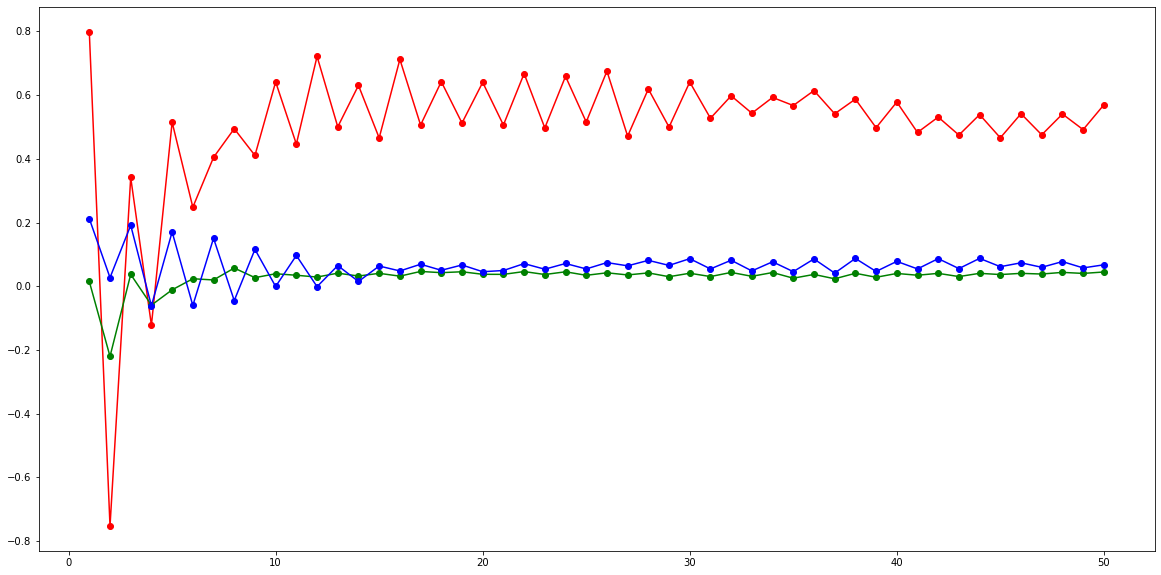

In [95]:
tt = np.linspace(-10, 10, 10)
b = [50, 2, 15]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
lr = [0.095, 0.002, 0.004]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

# n <= np.power(len(tt), 2)
n = 50
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr, scheduler=scheduler)[-1])

min_points = np.array(min_points)
print(np.abs((b - min_points)))
print(min_points)

plt.plot(np.linspace(1, n, n), (b - min_points)[:, 0], '-o', color='red')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 1], '-o', color='green')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 2], '-o', color='blue')

## SGM with momentum

[-0.34651742 -0.57133324]
[9.65348258 4.42866676]
[[ 0.00000000e+00  0.00000000e+00]
 [ 7.75482881e+00  2.06980473e+02]
 [ 2.25040334e+01 -7.49783334e+01]
 [ 3.12337731e+01  1.01331326e+01]
 [ 3.47394219e+01  4.44168658e+01]
 [ 3.26913478e+01 -1.08371002e+00]
 [ 2.78679542e+01 -6.33493004e+00]
 [ 2.11436467e+01  1.78800108e+01]
 [ 1.85978070e+01  6.69574295e-02]
 [ 1.57465725e+01  2.29913098e+00]
 [ 1.35224232e+01  8.07841919e+00]
 [ 1.15410866e+01  3.03237432e+00]
 [ 1.07769882e+01  3.15594882e+00]
 [ 1.00114489e+01  6.84454464e+00]
 [ 9.79789292e+00  5.42728925e+00]
 [ 9.75850459e+00  3.45606936e+00]
 [ 9.57334889e+00  4.95898149e+00]
 [ 9.28026742e+00  6.07292063e+00]
 [ 9.29850951e+00  5.01401370e+00]
 [ 9.65348258e+00  4.42866676e+00]]


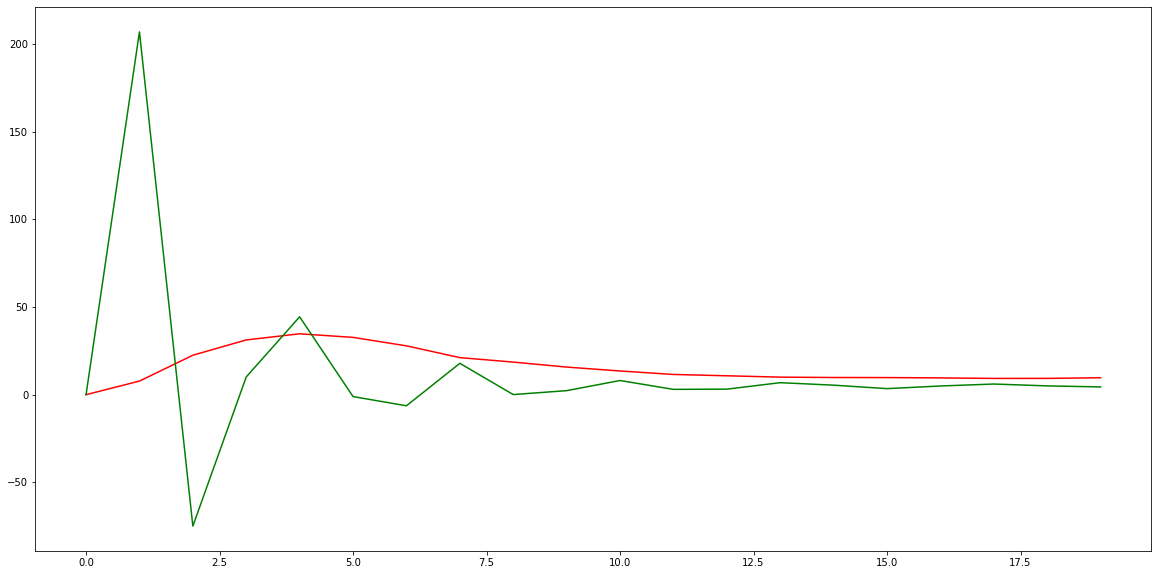

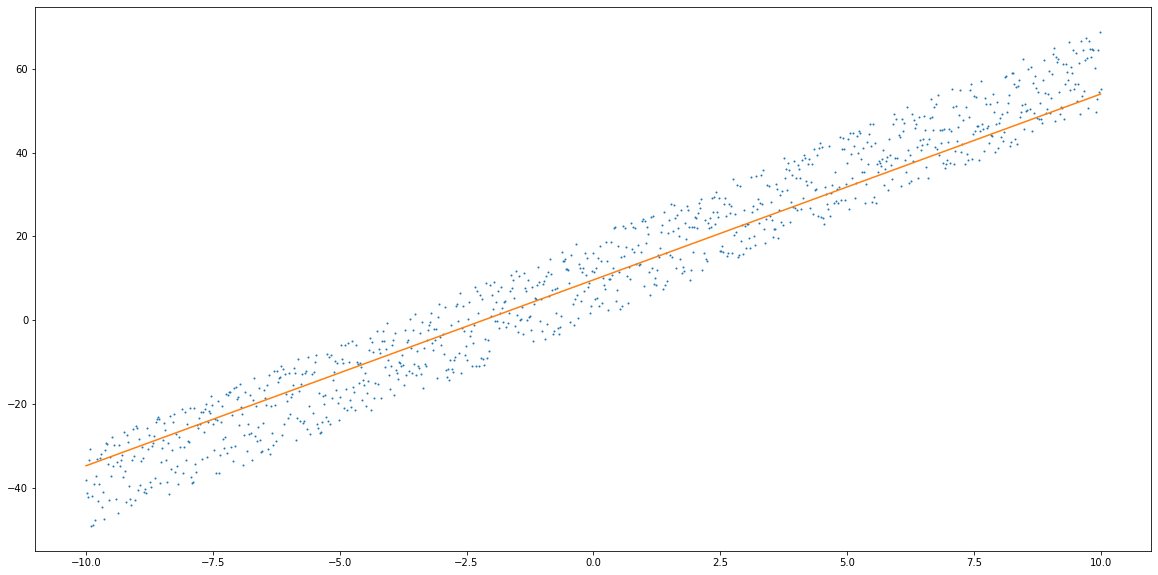

In [96]:
"""
Finds minimum of the function using stochastic gradient descent with momentum.

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_momentum(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = np.array(grad_appr(sum_fun, x, [0, batch_size]))
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x, [i * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [0.06, 0.03]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## Nesterov SGD

[ 0.92777886 -0.55031922]
[10.92777886  4.44968078]
[[  0.           0.        ]
 [ 12.69698391 191.95608765]
 [ 39.53730007 -68.92178721]
 [ 44.13050243 -64.35442169]
 [ 36.43521038  62.6845156 ]
 [ 27.27424643  -5.47525871]
 [ 19.95520324 -16.51641529]
 [ 16.17382145  18.05336019]
 [ 12.30738792   8.2138144 ]
 [  9.38304399  -3.51724583]
 [  7.55539972   9.12355139]
 [  7.05547051   8.5125619 ]
 [  7.74912392  -1.60106996]
 [  8.51605786   2.18275814]
 [  9.19121407  10.12563992]
 [ 10.14978743   4.05414963]
 [ 10.79375643   3.81890152]
 [ 11.08252753   6.13029026]
 [ 11.14666452   4.76535939]
 [ 10.92777886   4.44968078]]


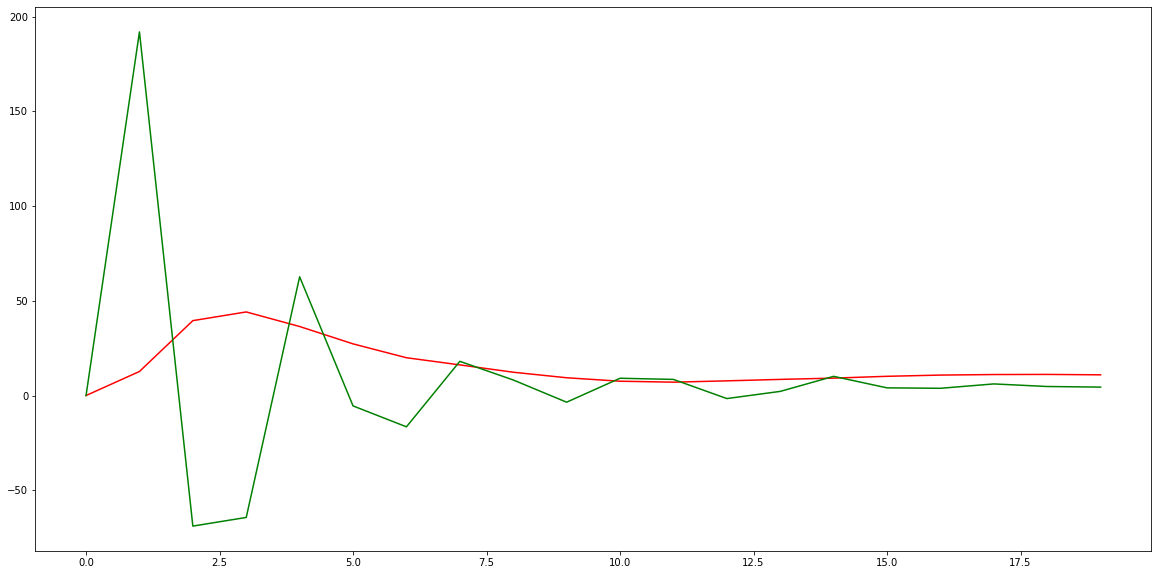

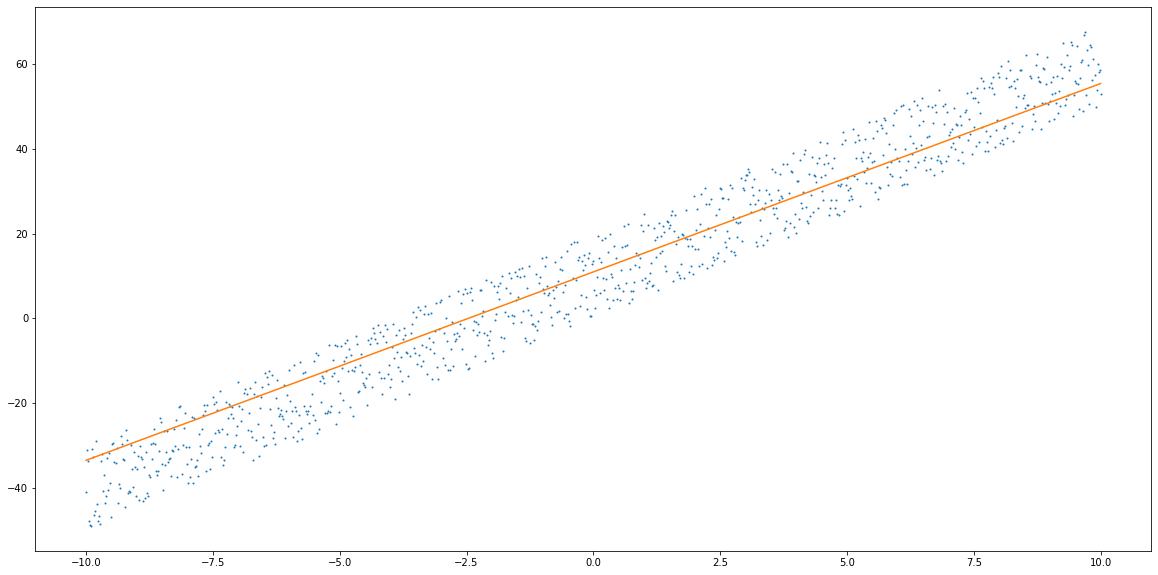

In [97]:
"""
Finds minimum of the function using stochastic gradient descent with Nesterov algorithm.
"""
def sgd_nesterov(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = 0
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x - b * g, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 60
lr = [0.06, 0.03]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with AdaGrad

[ 0.51696101 -0.14870356]
[19.48303899  5.14870356]
[[ 0.          0.        ]
 [20.         20.        ]
 [22.97785952  1.12248726]
 [24.36702176  4.96998838]
 [21.16830256  5.22543279]
 [19.83453992  4.91673096]
 [20.55750388  4.89702302]
 [19.45210356  4.61900103]
 [19.36848653  5.13562136]
 [18.53430864  4.7468389 ]
 [19.14971212  5.17386274]
 [20.78844589  5.35993569]
 [19.74133595  4.80659362]
 [20.21104271  4.98848432]
 [19.03327278  5.04057621]
 [20.32212222  5.1223872 ]
 [18.75821455  5.0094742 ]
 [20.58669176  4.96344488]
 [18.34179428  4.62667951]
 [19.48303899  5.14870356]]


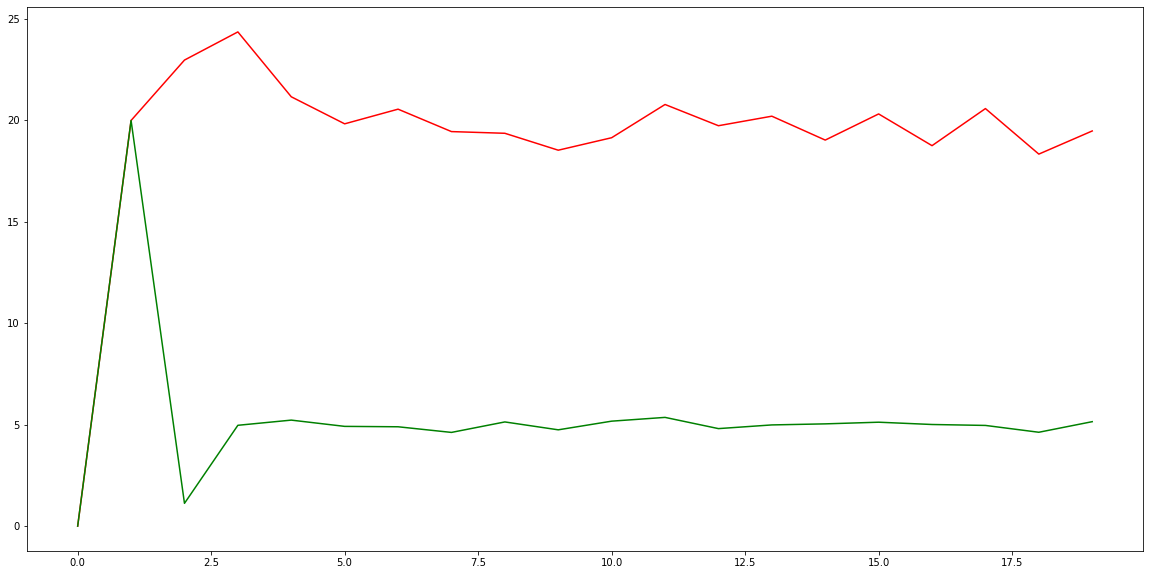

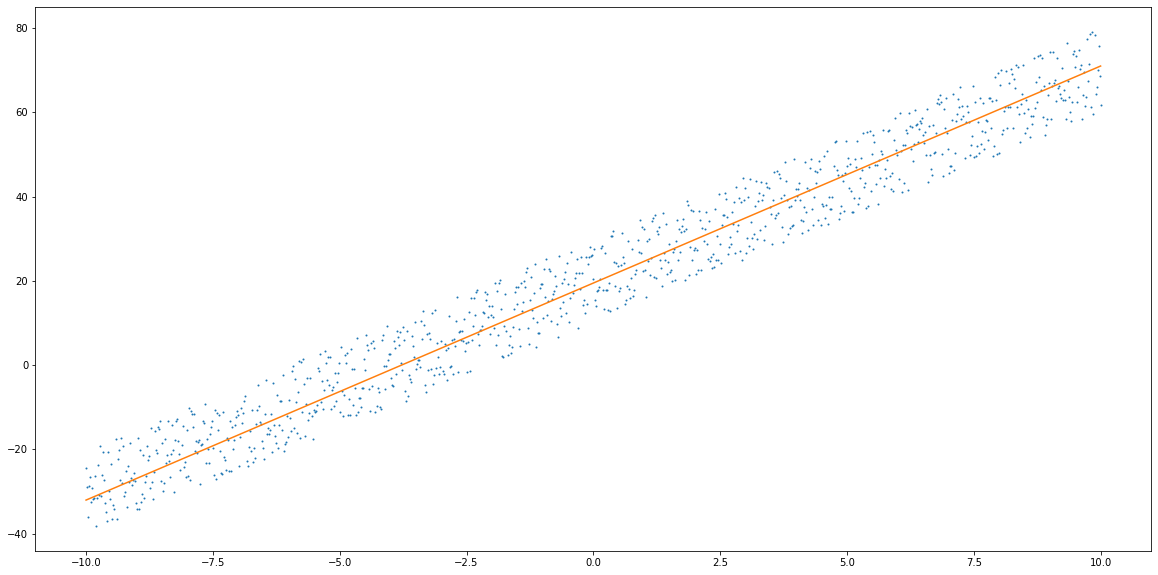

In [98]:
"""
Finds minimum of the function using stochastic gradient descent with AdaGrad (adaptive gradient).

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_adagrad(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v += np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [20, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [1000]

points = sgd_adagrad(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with RMSProp

[ 1.06763185 -0.73415291]
[13.93236815  5.73415291]
[[ 0.          0.        ]
 [ 4.42718872  4.42718872]
 [ 6.73509982  5.39035158]
 [ 8.44253208  4.83551436]
 [ 9.62957875  4.8040226 ]
 [10.71089999  4.90302862]
 [11.66195023  4.94809678]
 [12.30374135  5.26575989]
 [13.22951328  4.68755308]
 [13.46342622  5.06111474]
 [13.94928703  4.72260061]
 [14.23009903  5.69460385]
 [14.2938774   4.31644249]
 [14.26353299  5.9892468 ]
 [14.09580834  4.20020598]
 [14.36149454  5.89390462]
 [14.59003112  4.74212795]
 [14.96652597  5.53123595]
 [14.36670821  4.65280981]
 [13.93236815  5.73415291]]


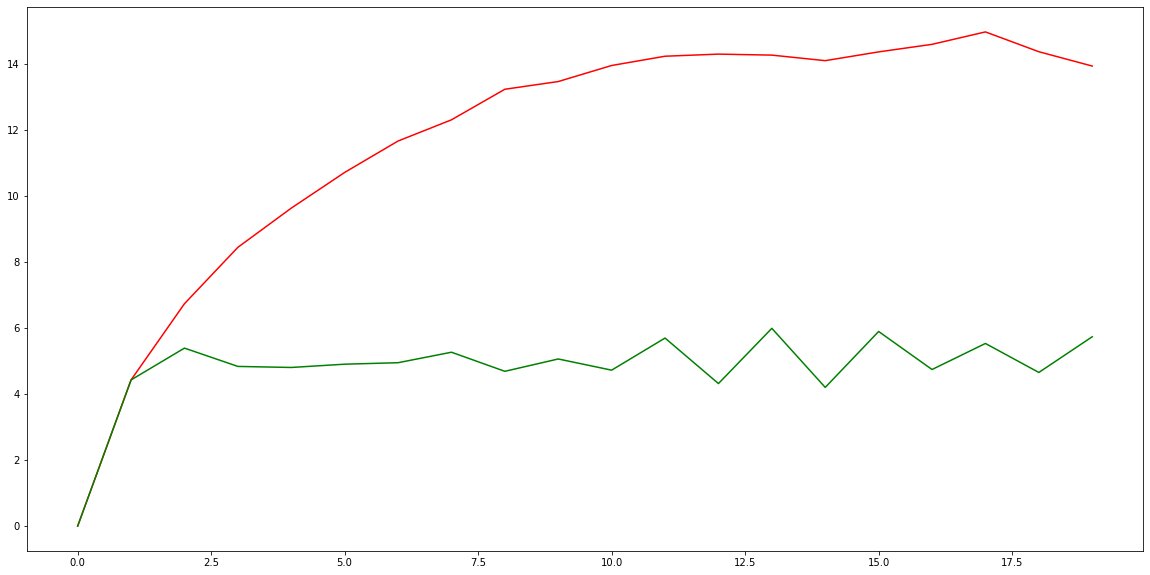

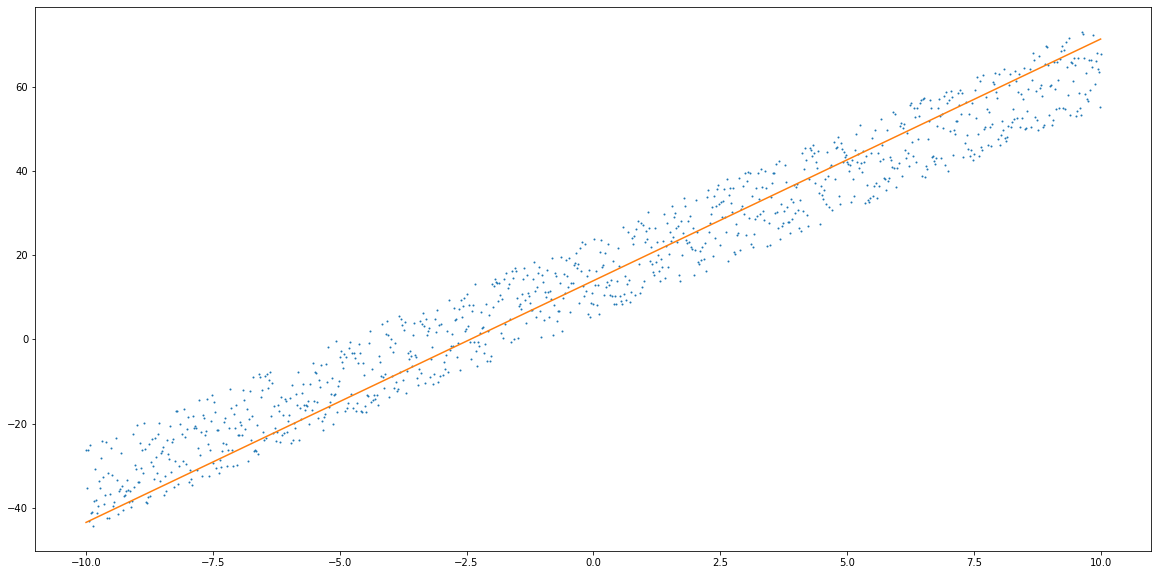

In [99]:
"""
Finds minimum of the function using stochastic gradient descent with rmsprop.
"""
def sgd_rmsprop(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b = np.array(b)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v = b * v + (1 - b) * np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [70]
b = [0.9]

points = sgd_rmsprop(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with Adam

[-0.05282598 -0.44563969]
[15.05282598  5.44563969]
[[ 0.          0.        ]
 [ 0.95122942  0.95122942]
 [ 1.96463558  1.95525779]
 [ 2.79358132  2.78377129]
 [ 3.58115617  3.50574402]
 [ 4.36285003  4.11090877]
 [ 5.16487928  4.65032072]
 [ 5.94389346  5.05788131]
 [ 6.71101948  5.25389116]
 [ 7.49602412  5.40974462]
 [ 8.33233648  5.1610646 ]
 [ 9.1735823   5.03714341]
 [ 9.99820702  4.86889649]
 [10.85781715  4.54798374]
 [11.64238652  4.69031946]
 [12.39862978  5.12096846]
 [13.16624212  5.08846743]
 [13.92350326  4.98992254]
 [14.43105951  4.87204297]
 [15.05282598  5.44563969]]


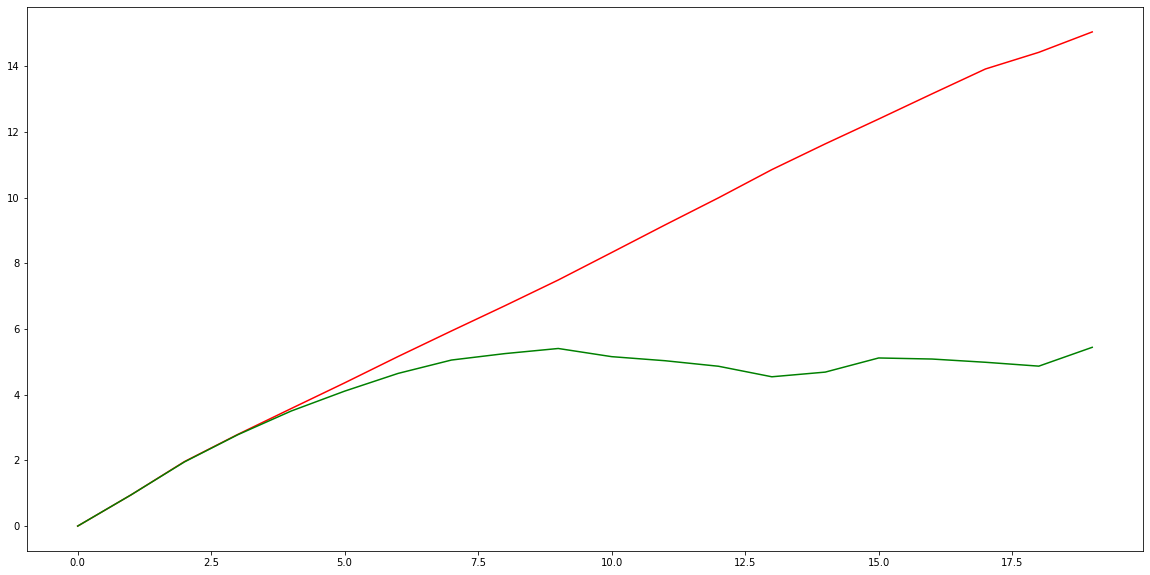

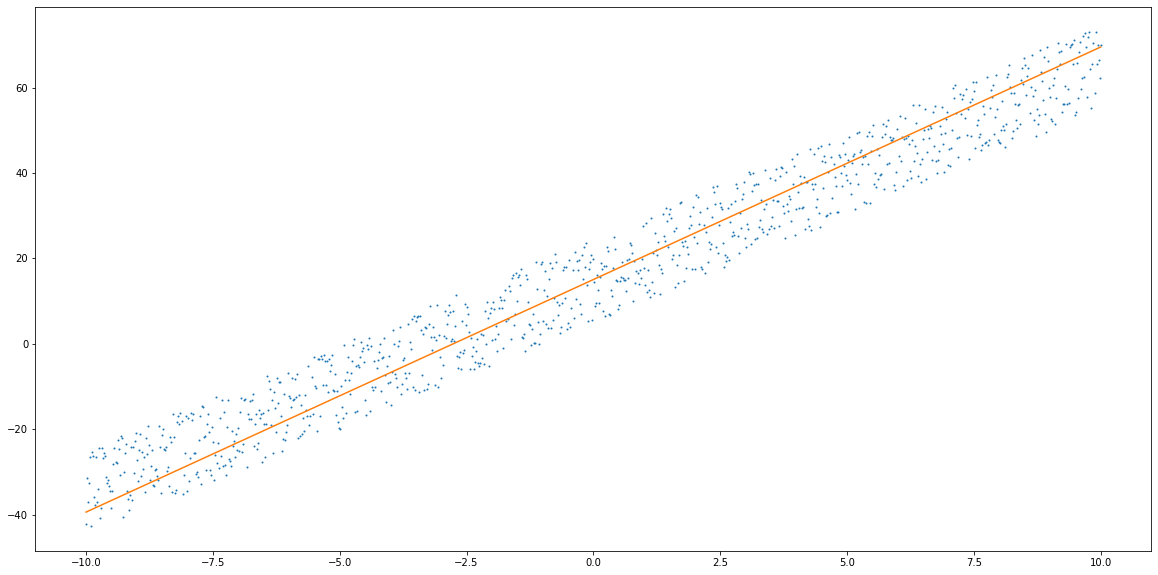

In [100]:
"""
Finds minimum of the function using stochastic gradient descent with adam.
"""
def sgd_adam(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    m = 0
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [50]
b1 = [0.5]
b2 = [0.6]
scheduler = lambda lr: lr * np.exp(-0.05)

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])